### Transformations

In [10]:
from monai.transforms import (
    EnsureChannelFirst,
    EnsureChannelFirstd,
    Compose,
    CropForeground,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    ScaleIntensityRanged,
    Spacing,
    Spacingd,
    ScaleIntensityRange,
    Orientationd,
)

val_transforms = Compose(
    [
        EnsureChannelFirstd(keys='image'),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=['image'], source_key="image"),
        Orientationd(keys=['image'], axcodes="RAS"),
        Spacingd(keys=['image'], pixdim=(1.5, 1.5, 2.0), mode=("bilinear")),
    ]
)

post_processing = Compose(
    [
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0.0,
            a_max=1.0,
            b_min=-1000.0,
            b_max=2976.0,
        ),
        Orientationd(keys=['image'], axcodes="RAS"),
    ]
)




monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


### Load the image to use for inference

In [4]:
contour_path = '../Prostate Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/0.000000-Contouring-60430/1-1.dcm'
dicom_dir = '../Prostate Dataset/Prostate-AEC-001/11-17-1992-NA-RX SIMULATION-82988/2.000000-Pelvis-13578'
weights_path = '../best_metric_model.pth'
output_path = '../mask.dcm'

In [5]:
# Constants
colorsD = {
        'red': [255, 0, 0],
        'green': [0, 255, 0],
        'blue': [0, 0, 255],
        'yellow': [255, 255, 0],
        'purple': [128, 0, 128]
    }

In [6]:
import torch
import numpy as np
from monai.transforms import Compose, EnsureChannelFirstd, ScaleIntensityRanged, CropForegroundd, Orientationd, Spacingd
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import SimpleITK as sitk
from rt_utils import RTStructBuilder
from monai.inferers import sliding_window_inference


def intialize_model(weights_path):
    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)

    # Load saved weights
    model.load_state_dict(torch.load(weights_path))
    model.eval()  # Set the model to evaluation mode
    
    return model, device


def create_rtstruct(dicom_dir, output_path, mask_array, roi_name, roi_color):
    
    # Create new RT Struct. Requires the DICOM series path for the RT Struct.
    rtstruct = RTStructBuilder.create_new(dicom_series_path= dicom_dir)
   
    rtstruct.add_roi(
        mask= mask_array, 
        color= colorsD[roi_color], 
        name= roi_name
    )
    rtstruct.save(output_path)


def read_dicom(dicom_dir):
    data = {'image': dicom_dir}
    data = LoadImaged(keys='image')(data)
    
    preprocessed_data = val_transforms(data) # PreProcess
    
    preprocessed_data = preprocessed_data['image'].unsqueeze(0) # Add Batch

    return preprocessed_data

In [67]:
def infer(dicom_dir, weights_path, output_path):
    
    model, device = intialize_model(weights_path)
    
    image_dict = read_dicom(dicom_dir) # {image: metaTensor, .meta for metadata, .applied_operations for transformations history}
    
    # Perform sliding window inference on the single image
    roi_size = (96, 96, 96)
    sw_batch_size = 4 
    
    with torch.no_grad():
        output = sliding_window_inference(image_dict['image'].to(device), roi_size, sw_batch_size, model)

    
    predicted_output = torch.argmax(output, dim=1).detach().cpu().numpy().astype(bool)

    
    # Create and save the RTStruct
    create_rtstruct(dicom_dir, output_path, predicted_output.squeeze(0), "Prostate", "red")
    
    return predicted_output

In [7]:
image = read_dicom(dicom_dir)
image.size()

torch.Size([1, 1, 298, 276, 179])

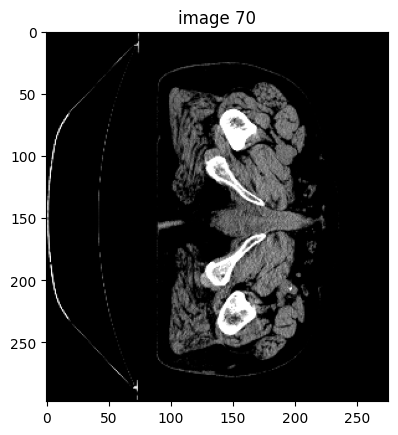

In [8]:
import matplotlib.pyplot as plt

slice_num = 70

plt.figure("check")
plt.title(f"image {slice_num}")
plt.imshow(image.numpy()[0,0,:, :, slice_num], cmap="gray")
plt.show()

# plt.figure("check")
# plt.title(f"image {slice_num+i}")
# plt.imshow(output.numpy()[0,slice_num+i, :, :], cmap="gray")
# plt.show()

In [11]:
output = val_transforms.inverse(image.squeeze(0))

RuntimeError: applying transform <bound method Spacingd.inverse of <monai.transforms.spatial.dictionary.Spacingd object at 0x000002785E9F6270>>

In [89]:
output.size()

torch.Size([1, 179, 1024, 1024])